In [22]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

from sklearn.model_selection import train_test_split

In [2]:
class CustomDataset(Dataset):
    def __init__(self, dataset_dir: Path, annotations_path: Path, transform=None) -> None:
        super().__init__()
        self.dataset_dir = dataset_dir
        self.df = pd.read_csv(annotations_path)
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        observation = self.df.iloc[index, :]
        image1_path = self.dataset_dir / str(observation['label1']) / observation['image1']
        image2_path = self.dataset_dir / str(observation['label2']) / observation['image2']

        image1 = Image.open(image1_path).convert('RGB')
        image2 = Image.open(image2_path).convert('RGB')
        similarity = [float(observation['similarity'])]

        if self.transform is not None:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        return image1, image2, torch.FloatTensor(similarity)

In [19]:
annotations_path = Path("dataset.csv")
dataset_dir = Path("curated_dataset")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CustomDataset(dataset_dir=dataset_dir,
                        annotations_path=annotations_path,
                        transform=transform)

dataset_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [23]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train Dataset size: {len(train_dataset)}")
print(f"Test Dataset size: {len(test_dataset)}")

Train Dataset size: 262
Test Dataset size: 66


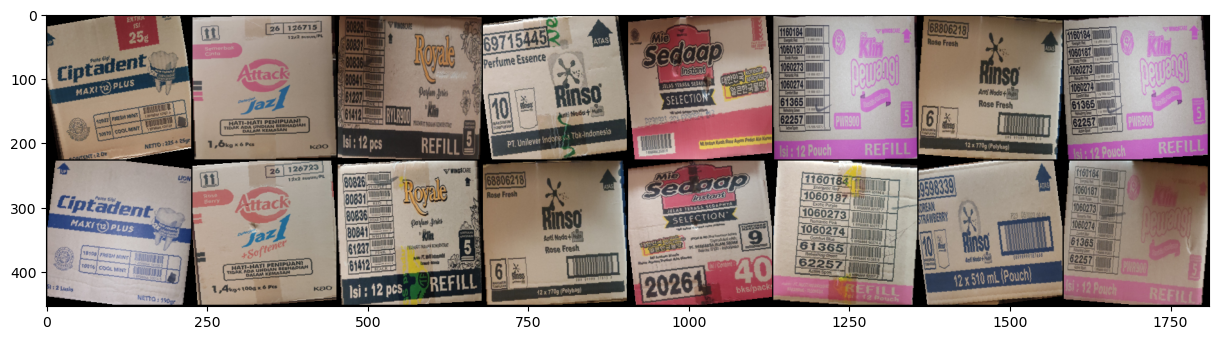

Labels: [1. 1. 1. 1. 0. 1. 1. 1.]


In [20]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    if text is not None:
        plt.text(75, 8, text, ha='center', va='top', color='black', fontsize=16)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(dataset_loader)
example_batch = next(dataiter)

# Separate the batch into images and labels
concatenated_images = torch.cat((example_batch[0], example_batch[1]), 0)
labels = example_batch[2]

# Show images with labels
imshow(torchvision.utils.make_grid(concatenated_images))
print('Labels:', labels.numpy().reshape(-1))
